## Rules
---
<img style="float:left" src="Maze.png" alt="drawing" width="300"/>

> Consider the simple maze shown inset in the Figure. In each of the 47 states there are four actions, `up`, `down`, `right`, and `left`, which take the agent deterministically to the corresponding neighboring states, except when movement is blocked by an obstacle or the edge of the maze, in which case the agent remains where it is. Reward is zero on all transitions, except those into the goal state, on which it is +1. After reaching the goal state `(G)`, the agent returns to the start state `(S)` to begin a new episode.
---
>
## Dyna-Q

---
<img style="float:left" src="Tabular_Dyna-Q.png" alt="drawing" width="600"/>

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
ROWS = 6
COLS = 9
S = (2, 0)
G = (0, 8)
BLOCKS = [(1, 2), (2, 2), (3, 2), (0, 7), (1, 7), (2, 7), (4, 5)]
ACTIONS = ["left", "up", "right", "down"]

### Models

In [3]:
class Maze:
    
    def __init__(self):
        self.rows = ROWS
        self.cols = COLS
        self.start = S
        self.goal = G
        self.blocks = BLOCKS
        self.state = S
        self.end = False
        # init maze
        self.maze = np.zeros((self.rows, self.cols))
        for b in self.blocks:
            self.maze[b] = -1
            
    def nxtPosition(self, action):
        r, c = self.state
        if action == "left":
            c -= 1
        elif action == "right":
            c += 1
        elif action == "up":
            r -= 1
        else:
            r += 1
        
        if (r >= 0 and r <= self.rows-1) and (c >= 0 and c <= self.cols-1):
            if (r, c) not in self.blocks:
                self.state = (r, c)
        return self.state
    
    def giveReward(self):
        if self.state == self.goal:
            self.end = True
            return 1
        else:
            return 0
        
    def showMaze(self):
        self.maze[self.state] = 1
        for i in range(0, self.rows):
            print('-------------------------------------')
            out = '| '
            for j in range(0, self.cols):
                if self.maze[i, j] == 1:
                    token = '*'
                if self.maze[i, j] == -1:
                    token = 'z'
                if self.maze[i, j] == 0:
                    token = '0'
                out += token + ' | '
            print(out)
        print('-------------------------------------')

In [4]:
m = Maze()
m.showMaze()

-------------------------------------
| 0 | 0 | 0 | 0 | 0 | 0 | 0 | z | 0 | 
-------------------------------------
| 0 | 0 | z | 0 | 0 | 0 | 0 | z | 0 | 
-------------------------------------
| * | 0 | z | 0 | 0 | 0 | 0 | z | 0 | 
-------------------------------------
| 0 | 0 | z | 0 | 0 | 0 | 0 | 0 | 0 | 
-------------------------------------
| 0 | 0 | 0 | 0 | 0 | z | 0 | 0 | 0 | 
-------------------------------------
| 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 
-------------------------------------


In [29]:
class DynaAgent:
    
    def __init__(self, exp_rate=0.3, lr=0.1, n_steps=5, episodes=1):
        self.maze = Maze()
        self.state = S
        self.actions = ACTIONS
        self.state_actions = []  # state & action track
        self.exp_rate = exp_rate
        self.lr = lr
        
        self.steps = n_steps
        self.episodes = episodes  # number of episodes going to play
        self.steps_per_episode = []
        
        self.Q_values = {}
        # model function
        self.model = {}
        for row in range(ROWS):
            for col in range(COLS):
                self.Q_values[(row, col)] = {}
                for a in self.actions:
                    self.Q_values[(row, col)][a] = 0
        
    def chooseAction(self):
        # epsilon-greedy
        mx_nxt_reward = -999
        action = ""
        
        if np.random.uniform(0, 1) <= self.exp_rate:
            action = np.random.choice(self.actions)
        else:
            # greedy action
            current_position = self.state
            # if all actions have same value, then select randomly
            if len(set(self.Q_values[current_position].values())) == 1:
                action = np.random.choice(self.actions)
            else:
                for a in self.actions:
                    nxt_reward = self.Q_values[current_position][a]
                    if nxt_reward >= mx_nxt_reward:
                        action = a
                        mx_nxt_reward = nxt_reward
        return action
    
    def reset(self):
        self.maze = Maze()
        self.state = S
        self.state_actions = []
    
    def play(self):
        self.steps_per_episode = []  
        
        for ep in range(self.episodes):    
            while not self.maze.end:

                action = self.chooseAction()
                self.state_actions.append((self.state, action))

                nxtState = self.maze.nxtPosition(action)
                reward = self.maze.giveReward()
                # update Q-value
                self.Q_values[self.state][action] += self.lr*(reward + np.max(list(self.Q_values[nxtState].values())) - self.Q_values[self.state][action])

                # update model
                self.model[self.state] = {}
                self.model[self.state][action] = (reward, nxtState)
                self.state = nxtState

                # loop n times to randomly update Q-value
                for _ in range(self.steps):
                    # randomly choose an state
                    rand_idx = np.random.choice(range(len(self.model.keys())))
                    _state = list(self.model)[rand_idx]
                    # randomly choose an action
                    rand_idx = np.random.choice(range(len(self.model[_state].keys())))
                    _action = list(self.model[_state])[rand_idx]

                    _reward, _nxtState = self.model[_state][_action]

                    self.Q_values[_state][_action] += self.lr*(_reward + np.max(list(self.Q_values[_nxtState].values())) - self.Q_values[_state][_action])       
            # end of game
            if ep % 10 == 0:
                print("episode", ep)
            self.steps_per_episode.append(len(self.state_actions))
            self.reset()
                  

### Steps comparison

In [17]:
N_EPISODES = 50

In [24]:
agent = DynaAgent(n_steps=0, episodes=N_EPISODES)
agent.play()

steps_episode_0 = agent.steps_per_episode

episode 0
episode 10
episode 20
episode 30
episode 40


In [25]:
agent = DynaAgent(n_steps=5, episodes=N_EPISODES)
agent.play()

steps_episode_5 = agent.steps_per_episode

episode 0
episode 10
episode 20
episode 30
episode 40


In [26]:
agent = DynaAgent(n_steps=50, episodes=N_EPISODES)
agent.play()

steps_episode_50 = agent.steps_per_episode

episode 0
episode 10
episode 20
episode 30
episode 40


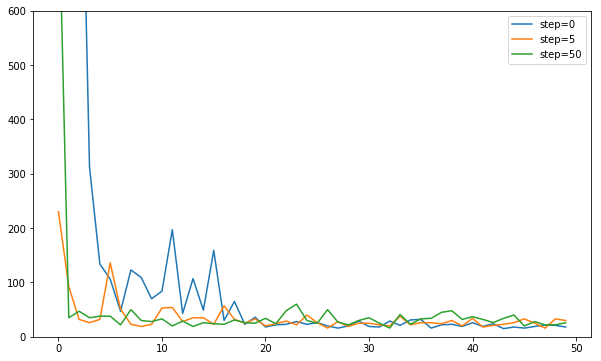

In [28]:
plt.figure(figsize=[10, 6])

plt.ylim(0, 600)
plt.plot(range(N_EPISODES), steps_episode_0, label="step=0")
plt.plot(range(N_EPISODES), steps_episode_5, label="step=5")
plt.plot(range(N_EPISODES), steps_episode_50, label="step=50")

plt.legend()

### DynaQ+

In [126]:
class DynaAgentPlus:
    
    def __init__(self, exp_rate=0.3, lr=0.1, n_steps=5, episodes=1, timeWeight=1e-4):
        self.time = 0  # keep track of the total time
        self.timeWeight = timeWeight
        self.maze = Maze()
        self.state = S
        self.actions = ACTIONS
        self.state_actions = []  # state & action track
        self.exp_rate = exp_rate
        self.lr = lr
        
        self.steps = n_steps
        self.episodes = episodes  # number of episodes going to play
        self.steps_per_episode = []
        
        self.Q_values = {}
        # model function
        self.model = {}
        for row in range(ROWS):
            for col in range(COLS):
                self.Q_values[(row, col)] = {}
                self.model[(row, col)] = {}
                for a in self.actions:
                    self.Q_values[(row, col)][a] = 0
                    self.model[(row, col)][a] = (0, (0, 0), 0)  # reward & next state & #times been tried
        
    def chooseAction(self):
        # epsilon-greedy
        mx_nxt_reward = -999
        action = ""
        
        if np.random.uniform(0, 1) <= self.exp_rate:
            action = np.random.choice(self.actions)
        else:
            # greedy action
            current_position = self.state
            # if all actions have same value, then select randomly
            if len(set(self.Q_values[current_position].values())) == 1:
                action = np.random.choice(self.actions)
            else:
                for a in self.actions:
                    nxt_reward = self.Q_values[current_position][a]
                    if nxt_reward >= mx_nxt_reward:
                        action = a
                        mx_nxt_reward = nxt_reward
        return action
    
    def reset(self):
        self.maze = Maze()
        self.state = S
        self.state_actions = []
        
    def updateModel(self, state, action, reward):
        for a in self.actions:
            # the initial model for such actions was that they would 
            # lead back to the same state with a reward of 0.
            if a != action:
                _, _, time = self.model[state][a]
                self.model[state][a] = (0, state, time)  # time remains the same
        time = self.model[state][action][2]
        self.model[state][action] = (reward, nxtState, time+1)
    
    def play(self):
        self.steps_per_episode = []  
        
        for ep in range(self.episodes):    
            while not self.maze.end:

                action = self.chooseAction()
                self.state_actions.append((self.state, action))

                nxtState = self.maze.nxtPosition(action)
                reward = self.maze.giveReward()
#                 print("nxt", nxtState, self.state)
                # update Q-value
                self.Q_values[self.state][action] += self.lr*(reward + np.max(list(self.Q_values[nxtState].values())) - self.Q_values[self.state][action])

                # update model
                for a in self.actions:
                    # the initial model for such actions was that they would 
                    # lead back to the same state with a reward of 0.
                    if a != action:
                        time = self.model[self.state][a][2]
                        self.model[self.state][a] = (0, self.state, time)  # time remains the same
                
                time = self.model[self.state][action][2]
                self.model[self.state][action] = (reward, nxtState, time+1)
                
                self.state = nxtState
                self.time += 1 

                # loop n times to randomly update Q-value
                for _ in range(self.steps):
                    # randomly choose an state
                    rand_idx = np.random.choice(range(len(self.model.keys())))
                    _state = list(self.model)[rand_idx]
                    # randomly choose an action
                    rand_idx = np.random.choice(range(len(self.model[_state].keys())))
                    _action = list(self.model[_state])[rand_idx]

                    _reward, _nxtState, _time = self.model[_state][_action]
                    # update _reward
                    _reward += self.timeWeight*np.sqrt(self.time - _time)

                    self.Q_values[_state][_action] += self.lr*(_reward + np.max(list(self.Q_values[_nxtState].values())) - self.Q_values[_state][_action])       
            # end of game
            if ep % 10 == 0:
                print("episode", ep)
            self.steps_per_episode.append(len(self.state_actions))
            self.reset()                

In [127]:
agent = DynaAgentPlus(n_steps=5, episodes=5)  # took relatively long
agent.play()

episode 0
